## Data

Before running this notebook, be sure to follow these steps:

1. Download the three datasets containing 311 data from 2010 to 2024 from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/CVKM87

2. Download the Boston social vulnerability dataset from https://data.boston.gov/dataset/climate-ready-boston-social-vulnerability

3. Place all four .csv files into the ``data`` folder

4. If everything works correctly, you should see a pandas dataframe with 45 columns after the last cell, with the final column containing the Social Vulnerability Index we calculated

In [1]:
import pandas as pd
import numpy as np

Reads the three .csv files containing 311 data:

In [2]:
df1 = pd.read_csv('../data/311 Cases 2010_2014 Unrestricted.csv')
df2 = pd.read_csv('../data/311 Cases 2015_2019 Unrestricted.csv')
df3 = pd.read_csv('../data/311 Cases 2020_2024 Unrestricted.csv')

C:\Users\ivanb\AppData\Local\Temp\ipykernel_20808\2849313675.py:3: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('../data/311 Cases 2020_2024 Unrestricted.csv')


Concatenates all three subsets into one large dataset:

In [3]:
df = pd.concat([df1, df2, df3])

Drops rows that do not contain the GEOID needed to match Boston Social Vulnerability data:

In [4]:
df.dropna(subset=["CT_ID_10"], inplace=True)

Converts the GEOID from float to int:

In [5]:
df["CT_ID_10"] = df["CT_ID_10"].astype(np.int64)

Save the stacked dataframes:

In [ ]:
df.to_csv("../data/311_cases.csv", index=False)

Reads the Social Vulnerability csv as pandas dataframe:

In [2]:
sv_df = pd.read_csv('../data/Climate_Ready_Boston_Social_Vulnerability.csv')
df = pd.read_csv("../data/311_cases.csv")

C:\Users\ivanb\AppData\Local\Temp\ipykernel_15872\1667692635.py:2: DtypeWarning: Columns (16,17,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/311_cases.csv")


Calculates the Social Vulnerability Index by adding all the socially vulnerable category populations and dividing by the total population:

In [3]:
sv_df["SV_IDX"] = (sv_df["OlderAdult"] + sv_df["TotChild"] + sv_df["POC2"] + sv_df["LEP"] + sv_df["Low_to_No"] + sv_df["TotDis"] + sv_df["MedIllnes"]) / sv_df["POP100_RE"]

Since some citizens are present in more than one vulnerable group, we want to normalize this index from 0-1 by max-min normalization:

In [4]:
sv_df["SV_IDX"] = (sv_df["SV_IDX"] - sv_df["SV_IDX"].min()) / (sv_df["SV_IDX"].max() - sv_df["SV_IDX"].min())

Sanity check:

In [5]:
sv_df.head()

,FID,GEOID10,AREA_SQFT,AREA_ACRES,POP100_RE,HU100_RE,TotDis,TotChild,OlderAdult,Low_to_No,LEP,POC2,MedIllnes,Name,Shape__Area,Shape__Length,SV_IDX
0,1,25025010405,3914567.54,89.8661,5522,994,470,60,331,1191,1522,1755,2131.22,Mission Hill,666100.000000,6036.192907,0.251273
1,2,25025010404,1472713.92,33.8089,5817,1862,299,77,56,2387,2443,1749,2201.14,Fenway,250612.382812,2176.592171,0.332280
2,3,25025010801,1376667.12,31.6039,2783,1899,84,281,390,72,462,447,1214.76,Back Bay,234357.910156,2542.043078,0.150050
3,4,25025010702,3228780.12,74.1226,2400,1643,45,86,285,187,472,320,1014.20,Back Bay,549614.007812,3224.573044,0.130397
4,5,25025010204,2741497.18,62.9361,3173,1283,131,13,36,895,931,1039,1181.78,Fenway,466585.238281,3143.610637,0.244696


Joins the two datasets by the GEOID key:

In [6]:
df = df.join(sv_df.set_index('GEOID10'), on='CT_ID_10')

Since some 311 calls have GEOID not present in the Boston.gov dataset (likely typed in incorrectly), we remove those rows (~10k):

In [7]:
df.dropna(subset=["FID"], inplace=True)

The final column should be the Social Vulnerability Index we calculated ranging from 0 to 1:

In [8]:
df.head()

,Unnamed: 0,TYPE,CASE_ENQUIRY_ID,CLOSED_DT,LOCATION,OPEN_DT,REASON,SOURCE,SUBJECT,LocationID,...,TotChild,OlderAdult,Low_to_No,LEP,POC2,MedIllnes,Name,Shape__Area,Shape__Length,SV_IDX
0,179937.0,Electrical,101000102011,NaN,"227 Hanover St, Boston, MA 02113",2010-01-01,Building,Constituent Call,Inspectional Services,303291000.0,...,144.0,215.0,572.0,787.0,198.0,1020.89,North End,199108.652344,2510.837167,0.224366
1,180062.0,Electrical,101000101931,NaN,"4 Union Park St, Roxbury, MA 02118",2010-01-01,Building,Constituent Call,Inspectional Services,305963000.0,...,967.0,639.0,1544.0,2183.0,2498.0,2133.73,South End,544487.425781,3839.918949,0.453694
2,222060.0,Fire in Food Establishment,101000102010,NaN,"227 Hanover St, Boston, MA 02113",2010-01-01,Health,Constituent Call,Inspectional Services,303291000.0,...,144.0,215.0,572.0,787.0,198.0,1020.89,North End,199108.652344,2510.837167,0.224366
3,259240.0,General Lighting Request,101000102004,2010-03-10,"INTERSECTION of Mount Vernon St & Walnut St, B...",2010-01-01,Street Lights,Constituent Call,Public Works Department,NaN,...,595.0,541.0,280.0,821.0,411.0,1781.09,Back Bay,408899.921875,3149.451828,0.162949
4,271440.0,General Request,101000101992,2010-01-05,"223-231 Berkeley St, Boston, MA 02116",2010-01-01,General Request,Mobile Request,Mayor's 24 Hour Hotline,501239000.0,...,86.0,285.0,187.0,472.0,320.0,1014.20,Back Bay,549614.007812,3224.573044,0.130397


Let's get the total number of 311 calls per CTID:

In [9]:
count_calls_df = df.groupby(["CT_ID_10"])["CT_ID_10"].size().reset_index(name='NUM_CALLS')

count_calls_df

,CT_ID_10,NUM_CALLS
0,25025000100,18353
1,25025000201,13992
2,25025000202,13251
3,25025000301,10379
4,25025000302,10431
...,...,...
175,25025981501,795
176,25025981502,91
177,25025981600,106
178,25025981700,3906


Let's now join this table with the population, name, and SV index:

In [10]:
calls_svidx_df = count_calls_df.join(sv_df[["GEOID10", "POP100_RE", "Name", "SV_IDX"]].set_index('GEOID10'), on='CT_ID_10').dropna()

calls_svidx_df

,CT_ID_10,NUM_CALLS,POP100_RE,Name,SV_IDX
0,25025000100,18353,4254,Brighton,0.302320
1,25025000201,13992,3854,Brighton,0.209524
2,25025000202,13251,3885,Brighton,0.398954
3,25025000301,10379,2740,Brighton,0.274417
4,25025000302,10431,3142,Brighton,0.319505
...,...,...,...,...,...
173,25025981202,2067,207,South Boston Waterfront,0.000000
174,25025981300,1174,389,East Boston,0.111411
175,25025981501,795,12,Back Bay,0.072193
176,25025981502,91,9,East Boston,0.018031


Calculates the number of 311 calls per capita:

In [11]:
calls_svidx_df["CALLS_PER_POP"] = calls_svidx_df["NUM_CALLS"] / calls_svidx_df["POP100_RE"]

calls_svidx_df

,CT_ID_10,NUM_CALLS,POP100_RE,Name,SV_IDX,CALLS_PER_POP
0,25025000100,18353,4254,Brighton,0.302320,4.314292
1,25025000201,13992,3854,Brighton,0.209524,3.630514
2,25025000202,13251,3885,Brighton,0.398954,3.410811
3,25025000301,10379,2740,Brighton,0.274417,3.787956
4,25025000302,10431,3142,Brighton,0.319505,3.319860
...,...,...,...,...,...,...
173,25025981202,2067,207,South Boston Waterfront,0.000000,9.985507
174,25025981300,1174,389,East Boston,0.111411,3.017995
175,25025981501,795,12,Back Bay,0.072193,66.250000
176,25025981502,91,9,East Boston,0.018031,10.111111


Plot final results:

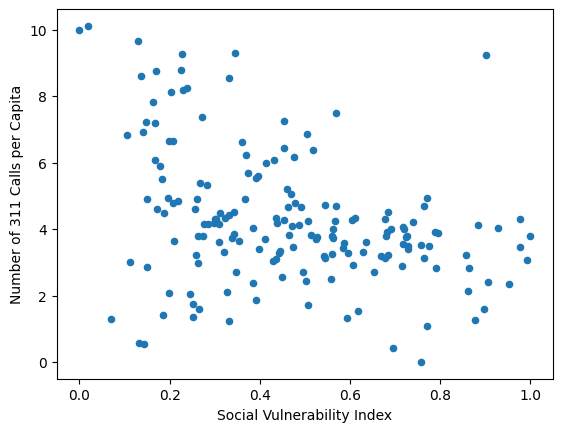

In [12]:
from matplotlib import pyplot as plt

calls_svidx_df[calls_svidx_df["CALLS_PER_POP"] < 30].plot.scatter(x = "SV_IDX", y = "CALLS_PER_POP")

plt.xlabel("Social Vulnerability Index")
plt.ylabel("Number of 311 Calls per Capita")
plt.show()

Save to csv file:

In [ ]:
calls_svidx_df.to_csv("data/calls_svidx_df.csv")

In [31]:
most = calls_svidx_df["CALLS_PER_POP"].sort_values()

top_rows = calls_svidx_df.nlargest(10, 'CALLS_PER_POP')
top_rows

,CT_ID_10,NUM_CALLS,POP100_RE,Name,SV_IDX,CALLS_PER_POP
169,25025980700,1110,6,Roslindale,0.710523,185.000000
175,25025981501,795,12,Back Bay,0.072193,66.250000
170,25025981000,1237,22,Roslindale,0.187461,56.227273
179,25025981800,3383,82,Jamaica Plain,0.079128,41.256098
176,25025981502,91,9,East Boston,0.018031,10.111111
173,25025981202,2067,207,South Boston Waterfront,0.000000,9.985507
29,25025010702,23186,2400,Back Bay,0.130397,9.660833
72,25025070300,36366,3909,Bay Village,0.345587,9.303147
46,25025040600,22631,2444,Charlestown,0.227252,9.259820
168,25025980300,3117,338,Jamaica Plain,0.902063,9.221893
